In [50]:
from openai import OpenAI
import pandas as pd
import os
import json
from dotenv import load_dotenv
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import lightgbm as lgb
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score



from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Load the API key from your .env
load_dotenv(dotenv_path=".env")  # You can give it the path explicitly
# Define api_key first
api_key = os.getenv("OPENAI_API_KEY")

https://www.kaggle.com/datasets/nair26/predictive-maintenance-of-machines/data

In [51]:
print("Loaded API key:", os.getenv("OPENAI_API_KEY")[:8] + "..." if os.getenv("OPENAI_API_KEY") else "❌ Not loaded")

Loaded API key: sk-proj-...


In [52]:

# Load the CSV file
df = pd.read_csv('Data/maintenance.csv')

# Display the first few rows of the DataFrame
df.sample(10)


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Vibration Levels,Operational Hours,Failure Type
29,30,L47209,L,299.0,309.4,1693,30.1,39.000000,25.38,No Failure
427,428,M15287,M,297.5,308.5,1496,42.2,31.746774,139.80,No Failure
387,388,L47567,L,297.7,308.7,1249,60.4,52.000000,125.62,No Failure
426,427,L47606,L,297.4,308.5,1501,44.9,32.028226,139.45,No Failure
305,306,L47485,L,297.8,308.4,2129,19.2,34.000000,96.55,No Failure
35,36,M14895,M,298.8,309.2,1452,48.6,33.435484,27.16,No Failure
325,326,L47505,L,297.8,308.5,1699,27.8,52.000000,103.64,No Failure
203,204,L47383,L,298.4,308.5,1490,37.9,55.000000,60.38,No Failure
234,235,L47414,L,298.2,308.4,1478,42.9,31.746774,71.37,No Failure
263,264,M15123,M,298.0,308.1,1587,32.3,52.000000,81.65,No Failure


Cleaning the data

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      500 non-null    int64  
 1   Product ID               500 non-null    object 
 2   Type                     500 non-null    object 
 3   Air temperature [K]      500 non-null    float64
 4   Process temperature [K]  500 non-null    float64
 5   Rotational speed [rpm]   500 non-null    int64  
 6   Torque [Nm]              500 non-null    float64
 7   Vibration Levels         500 non-null    float64
 8   Operational Hours        500 non-null    float64
 9   Failure Type             500 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 39.2+ KB


In [54]:
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Vibration Levels           0
Operational Hours          0
Failure Type               0
dtype: int64

In [55]:
df.duplicated().sum()

0

In [56]:
df.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Vibration Levels           float64
Operational Hours          float64
Failure Type                object
dtype: object

In [57]:
# Removes any leading/trailing whitespace from column names to ensure consistent access
df.columns = df.columns.str.strip()


In [58]:
print(df.columns.tolist())


['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Vibration Levels', 'Operational Hours', 'Failure Type']


In [59]:
# Original full dataset
df_viz = df.copy()  # For visualization (keeps 'Failure Type')

# Training dataset
df_train = df.copy()
df_train['Failure Binary'] = df_train['Failure Type'].apply(lambda x: 0 if x == 'No Failure' else 1)
df_train = df_train.drop(['Failure Type', 'UDI', 'Product ID'], axis=1)

df_train.sample(10)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Vibration Levels,Operational Hours,Failure Binary
352,M,297.6,308.4,1507,46.0,38.000000,113.21,0
272,L,298.1,308.1,1484,40.4,55.000000,84.85,0
197,M,298.4,308.6,1527,40.9,44.000000,58.25,0
364,L,297.6,308.4,1407,55.2,45.000000,117.46,0
224,L,298.3,308.6,1584,29.3,34.561290,67.83,0
422,L,297.3,308.3,1333,55.2,33.154032,138.03,0
87,L,299.0,309.0,1544,31.8,54.000000,25.00,0
260,M,298.2,308.3,1522,49.1,24.429032,80.59,0
61,M,298.8,309.0,1592,38.2,26.117742,26.87,0
257,L,298.0,308.0,1615,29.5,25.273387,79.53,0


In [60]:
# Count occurrences of each class in the binary target
print(df_train['Failure Binary'].value_counts())

# Optional: Display as percentages for better clarity
print("\nPercentage breakdown:")
print(df_train['Failure Binary'].value_counts(normalize=True) * 100)


Failure Binary
0    467
1     33
Name: count, dtype: int64

Percentage breakdown:
Failure Binary
0    93.4
1     6.6
Name: proportion, dtype: float64


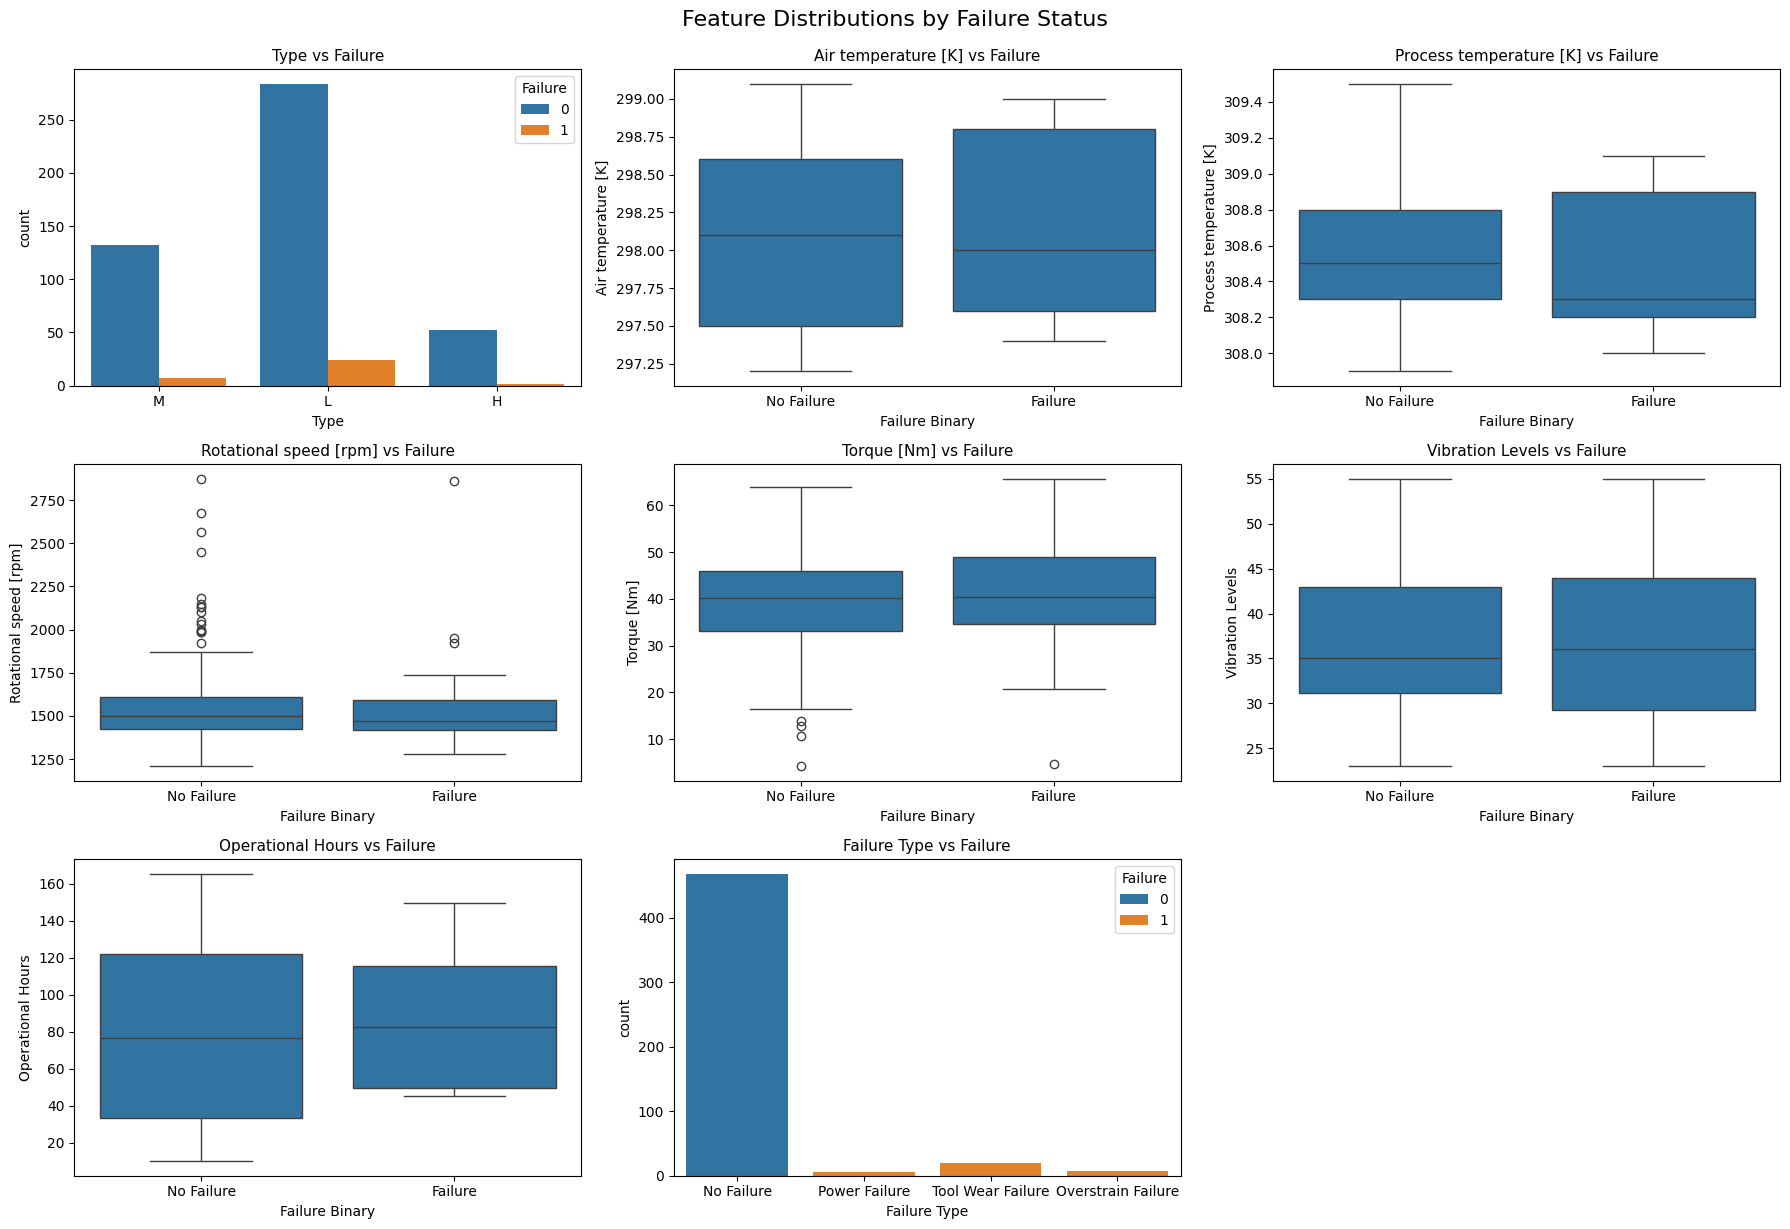

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Add Failure Binary to viz copy for consistency in plotting
df_viz['Failure Binary'] = df_viz['Failure Type'].apply(lambda x: 0 if x == 'No Failure' else 1)

# Features to plot (excluding only identifiers and target)
features = [col for col in df_viz.columns if col not in ['UDI', 'Product ID', 'Failure Binary']]

# Grid setup
cols = 3
rows = math.ceil(len(features) / cols)
plt.figure(figsize=(cols * 6, rows * 4))

for i, feature in enumerate(features, 1):
    plt.subplot(rows, cols, i)

    if df_viz[feature].nunique() <= 10 or df_viz[feature].dtype == 'object':
        sns.countplot(data=df_viz, x=feature, hue='Failure Binary')
        plt.legend(title='Failure', loc='upper right')
    else:
        sns.boxplot(data=df_viz, x='Failure Binary', y=feature)
        plt.xticks([0, 1], ['No Failure', 'Failure'])

    plt.title(f'{feature} vs Failure', fontsize=11)
    plt.tight_layout()

plt.suptitle('Feature Distributions by Failure Status', fontsize=16, y=1.02)
plt.show()


In [62]:
plt.savefig('Visualizations/feature_distributions_by_failure_status.png', bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

In [63]:
from scipy.stats import ttest_ind, mannwhitneyu
import numpy as np

# Identify numeric features for testing (exclude identifiers, categorical, and target columns)
numeric_features = [col for col in features if df_viz[col].dtype in [np.float64, np.int64]]

print("Comparing Failure=0 vs Failure=1:")

for feature in numeric_features:
    group0 = df_viz[df_viz['Failure Binary'] == 0][feature].dropna()
    group1 = df_viz[df_viz['Failure Binary'] == 1][feature].dropna()
    
    # Unpaired t-test (Welch's)
    t_stat, t_pvalue = ttest_ind(group0, group1, equal_var=False)
    
    # Mann-Whitney U test
    u_stat, u_pvalue = mannwhitneyu(group0, group1, alternative='two-sided')
    
    print(f"{feature}:")
    print(f"  T-test: t-statistic = {t_stat:.3f}, p-value = {t_pvalue:.4f}")
    print(f"  Mann-Whitney U test: U-statistic = {u_stat:.3f}, p-value = {u_pvalue:.4f}")



Comparing Failure=0 vs Failure=1:
Air temperature [K]:
  T-test: t-statistic = -0.023, p-value = 0.9814
  Mann-Whitney U test: U-statistic = 7627.500, p-value = 0.9228
Process temperature [K]:
  T-test: t-statistic = 1.562, p-value = 0.1269
  Mann-Whitney U test: U-statistic = 9131.500, p-value = 0.0741
Rotational speed [rpm]:
  T-test: t-statistic = -0.268, p-value = 0.7901
  Mann-Whitney U test: U-statistic = 8145.000, p-value = 0.5842
Torque [Nm]:
  T-test: t-statistic = -0.666, p-value = 0.5100
  Mann-Whitney U test: U-statistic = 7107.000, p-value = 0.4560
Vibration Levels:
  T-test: t-statistic = -0.312, p-value = 0.7571
  Mann-Whitney U test: U-statistic = 7146.500, p-value = 0.4856
Operational Hours:
  T-test: t-statistic = -1.018, p-value = 0.3151
  Mann-Whitney U test: U-statistic = 6812.000, p-value = 0.2656


In [64]:
import pandas as pd

data = {
    "Feature": [
        "Air temperature [K]",
        "Process temperature [K]",
        "Rotational speed [rpm]",
        "Torque [Nm]",
        "Vibration Levels",
        "Operational Hours"
    ],
    "T-test Statistic": [-0.023, 1.562, -0.268, -0.666, -0.312, -1.018],
    "T-test p-value": [0.9814, 0.1269, 0.7901, 0.5100, 0.7571, 0.3151],
    "Mann-Whitney U Statistic": [7627.5, 9131.5, 8145.0, 7107.0, 7146.5, 6812.0],
    "Mann-Whitney p-value": [0.9228, 0.0741, 0.5842, 0.4560, 0.4856, 0.2656]
}

df_results = pd.DataFrame(data)
df_results



,Feature,T-test Statistic,T-test p-value,Mann-Whitney U Statistic,Mann-Whitney p-value
0,Air temperature [K],-0.023,0.9814,7627.5,0.9228
1,Process temperature [K],1.562,0.1269,9131.5,0.0741
2,Rotational speed [rpm],-0.268,0.7901,8145.0,0.5842
3,Torque [Nm],-0.666,0.5100,7107.0,0.4560
4,Vibration Levels,-0.312,0.7571,7146.5,0.4856
5,Operational Hours,-1.018,0.3151,6812.0,0.2656


In [65]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

# scikit-learn models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# gradient boosting libraries
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# ==== 1. Prepare your data ====
X = df_train.drop('Failure Binary', axis=1)
y = df_train['Failure Binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==== 2. Feature engineering ====
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X_train.select_dtypes(exclude=['object', 'category']).columns.tolist()

# One-hot encode categorical
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = encoder.fit_transform(X_train[categorical_cols])
X_test_cat = encoder.transform(X_test[categorical_cols])

# Scale numeric
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numeric_cols])
X_test_num = scaler.transform(X_test[numeric_cols])

# Combine features
X_train_processed = np.hstack([X_train_num, X_train_cat])
X_test_processed = np.hstack([X_test_num, X_test_cat])

# ==== 3. SMOTE ====
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# ==== 4. Models ====
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
}

# ==== 5. Train + Evaluate ====
for name, model in models.items():
    print(f"\n{name} Classification Report:")
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_processed)
    print(classification_report(y_test, y_pred, digits=4))



Decision Tree Classification Report:
              precision    recall  f1-score   support

           0     0.9474    0.9677    0.9574        93
           1     0.4000    0.2857    0.3333         7

    accuracy                         0.9200       100
   macro avg     0.6737    0.6267    0.6454       100
weighted avg     0.9091    0.9200    0.9138       100


Random Forest Classification Report:
              precision    recall  f1-score   support

           0     0.9375    0.9677    0.9524        93
           1     0.2500    0.1429    0.1818         7

    accuracy                         0.9100       100
   macro avg     0.5938    0.5553    0.5671       100
weighted avg     0.8894    0.9100    0.8984       100


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0     0.9368    0.9570    0.9468        93
           1     0.2000    0.1429    0.1667         7

    accuracy                         0.9000       100
   macro a

c:\Users\Kristina Abramoff\repos\genai_sap_maintenance\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:57:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Kristina Abramoff\repos\genai_sap_maintenance\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0     0.9381    0.9785    0.9579        93
           1     0.3333    0.1429    0.2000         7

    accuracy                         0.9200       100
   macro avg     0.6357    0.5607    0.5789       100
weighted avg     0.8958    0.9200    0.9048       100



In [66]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report

# 1. Prepare data
X = df_train.drop('Failure Binary', axis=1)
y = df_train['Failure Binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Identify categorical and numeric columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X_train.select_dtypes(exclude=['object', 'category']).columns.tolist()

# 3. Encode categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = encoder.fit_transform(X_train[categorical_cols])
X_test_cat = encoder.transform(X_test[categorical_cols])

# 4. Scale numeric features
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numeric_cols])
X_test_num = scaler.transform(X_test[numeric_cols])

# 5. Combine numeric + categorical
X_train_processed = np.hstack([X_train_num, X_train_cat])
X_test_processed = np.hstack([X_test_num, X_test_cat])

# 6. Apply SMOTE on training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# 7. Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Bagging': BaggingClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# 8. Train and print classification reports
for name, model in models.items():
    print(f"\n{name} Classification Report:")
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_processed)
    print(classification_report(y_test, y_pred, digits=4))



Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0     0.9242    0.6559    0.7673        93
           1     0.0588    0.2857    0.0976         7

    accuracy                         0.6300       100
   macro avg     0.4915    0.4708    0.4324       100
weighted avg     0.8637    0.6300    0.7204       100


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0     0.9474    0.9677    0.9574        93
           1     0.4000    0.2857    0.3333         7

    accuracy                         0.9200       100
   macro avg     0.6737    0.6267    0.6454       100
weighted avg     0.9091    0.9200    0.9138       100


Random Forest Classification Report:
              precision    recall  f1-score   support

           0     0.9375    0.9677    0.9524        93
           1     0.2500    0.1429    0.1818         7

    accuracy                         0.9100       100
   macro

Can GEN AI DO BETTER?

In [27]:
from openai import OpenAI

client = OpenAI()

prompt = """
You are an experienced machine learning engineer.

I have a pandas DataFrame called `df_train` with a binary classification target column named `'Failure Binary'`.

Your task is to:

1. Preprocess the data:
   - Split into train and test sets (80/20 split, stratified).
   - One-hot encode all categorical variables (dtype object or category).
   - Standard scale numeric features.
   - Combine all features into a single matrix.

2. Automatically select and train the best classification model from this list:
   - Logistic Regression
   - Decision Tree
   - Random Forest
   - Gradient Boosting
   - AdaBoost
   - Bagging
   - Support Vector Machine (with probability=True)
   - K-Nearest Neighbors

3. Use appropriate hyperparameter tuning to optimize performance (GridSearchCV or similar).

4. Evaluate the final model:
   - Print the classification report (precision, recall, f1-score, support) on the test set.
   - Print the name of the best-performing model.

5. Analyze model explainability:
   - List the top 5 most important features that drive predictions.
   - For each, explain what value ranges indicate a high likelihood of engine failure.

Return only fully working Python code. No explanations, no markdown — just the raw code, ready to run.
"""


response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": prompt}],
    temperature=0.3,
    max_tokens=1500
)

print(response.choices[0].message.content)



```python
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              AdaBoostClassifier, BaggingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Preprocess the data
X = df_train.drop(columns=['Failure Binary'])
y = df_train['Failure Binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

categorical_features = X_train.select_dtypes(include=['object', 'category']).columns
numeric_features = X_train.select_dtypes(include=['int64', 'float64

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              AdaBoostClassifier, BaggingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Preprocess the data
X = df_train.drop(columns=['Failure Binary'])
y = df_train['Failure Binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

categorical_features = X_train.select_dtypes(include=['object', 'category']).columns
numeric_features = X_train.select_dtypes(exclude=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Bagging': BaggingClassifier(),
    'Support Vector Machine': SVC(probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

best_model = None
best_score = 0
best_model_name = ""

for model_name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', model)])
    
    param_grid = {}
    if model_name == 'Logistic Regression':
        param_grid = {'classifier__C': [0.01, 0.1, 1, 10, 100]}
    elif model_name == 'Decision Tree':
        param_grid = {'classifier__max_depth': [None, 5, 10, 20]}
    elif model_name == 'Random Forest':
        param_grid = {'classifier__n_estimators': [50, 100, 200],
                      'classifier__max_depth': [None, 5, 10, 20]}
    elif model_name == 'Gradient Boosting':
        param_grid = {'classifier__n_estimators': [50, 100, 200],
                      'classifier__learning_rate': [0.01, 0.1, 0.2]}
    elif model_name == 'AdaBoost':
        param_grid = {'classifier__n_estimators': [50, 100, 200]}
    elif model_name == 'Bagging':
        param_grid = {'classifier__n_estimators': [50, 100, 200]}
    elif model_name == 'Support Vector Machine':
        param_grid = {'classifier__C': [0.01, 0.1, 1, 10, 100],
                      'classifier__kernel': ['linear', 'rbf']}
    elif model_name == 'K-Nearest Neighbors':
        param_grid = {'classifier__n_neighbors': [3, 5, 7, 9]}

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_model = grid_search.best_estimator_
        best_model_name = model_name

# Evaluate the final model
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f'Best performing model: {best_model_name}')

# Analyze model explainability
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    feature_importances = best_model.named_steps['classifier'].feature_importances_
    feature_names = (np.concatenate([numeric_features, 
                                      best_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)]))
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(5)
    print(top_features)



              precision    recall  f1-score   support

           0       0.93      1.00      0.96        93
           1       0.00      0.00      0.00         7

    accuracy                           0.93       100
   macro avg       0.47      0.50      0.48       100
weighted avg       0.86      0.93      0.90       100

Best performing model: Gradient Boosting
                   Feature  Importance
5        Operational Hours    0.335549
0      Air temperature [K]    0.222459
4         Vibration Levels    0.151673
3              Torque [Nm]    0.112314
1  Process temperature [K]    0.089179


c:\Users\Kristina Abramoff\repos\genai_sap_maintenance\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Kristina Abramoff\repos\genai_sap_maintenance\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Kristina Abramoff\repos\genai_sap_maintenance\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              AdaBoostClassifier, BaggingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

# Step 1: Preprocess the data
X = df_train.drop(columns=['Failure Binary'])
y = df_train['Failure Binary']

# Split into train and test sets (80/20 split, stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Identify categorical and numeric columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# Create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Step 2: Automatically select the best classification model
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Bagging': BaggingClassifier(),
    'Support Vector Machine': SVC(probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

best_model = None
best_score = 0
best_model_name = ""

for model_name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', model)])
    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_test, y_test)
    
    if score > best_score:
        best_score = score
        best_model = pipeline
        best_model_name = model_name

# Step 3: Optimize the selected model using appropriate hyperparameters
if best_model_name in ['Random Forest', 'Gradient Boosting', 'AdaBoost', 'Bagging']:
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 5, 10],
        'classifier__min_samples_split': [2, 5]
    }
else:
    param_grid = {}

grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Step 4: Evaluate the final model
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Best Performing Model: {best_model_name}")

# Step 5: Analyze feature importance
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    importances = best_model.named_steps['classifier'].feature_importances_
elif hasattr(best_model.named_steps['classifier'], 'coef_'):
    importances = np.abs(best_model.named_steps['classifier'].coef_[0])
else:
    result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
    importances = result.importances_mean

# Get feature names after one-hot encoding
feature_names = (preprocessor.named_transformers_['cat']
                 .get_feature_names_out(categorical_cols))

# Combine feature names and importances
all_feature_names = np.concatenate([numeric_cols, feature_names])
feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(5)

print("Top 5 Most Important Features:")
print(top_features)



              precision    recall  f1-score   support

           0       0.94      0.99      0.96        93
           1       0.50      0.14      0.22         7

    accuracy                           0.93       100
   macro avg       0.72      0.57      0.59       100
weighted avg       0.91      0.93      0.91       100

Best Performing Model: Decision Tree
Top 5 Most Important Features:
                   Feature  Importance
5        Operational Hours    0.289110
4         Vibration Levels    0.260823
0      Air temperature [K]    0.246666
3              Torque [Nm]    0.099012
1  Process temperature [K]    0.063255


In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

# scikit-learn models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# additional models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import tensorflow_decision_forests as tfdf
import tensorflow as tf

# 1. Prepare data
X = df_train.drop('Failure Binary', axis=1)
y = df_train['Failure Binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Identify categorical and numeric columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X_train.select_dtypes(exclude=['object', 'category']).columns.tolist()

# 3. Encode categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = encoder.fit_transform(X_train[categorical_cols])
X_test_cat = encoder.transform(X_test[categorical_cols])

# 4. Scale numeric features
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numeric_cols])
X_test_num = scaler.transform(X_test[numeric_cols])

# 5. Combine numeric + categorical
X_train_processed = np.hstack([X_train_num, X_train_cat])
X_test_processed = np.hstack([X_test_num, X_test_cat])

# 6. Apply SMOTE on training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# 7. Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Bagging': BaggingClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
}

# 8. Train and print classification reports
for name, model in models.items():
    print(f"\n{name} Classification Report:")
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_processed)
    print(classification_report(y_test, y_pred, digits=4))

# 9. TensorFlow Decision Forests (TFDF)
print("\nTensorFlow Decision Forests Classification Report:")

# Create dataframe with processed features + label
Xy_train = pd.DataFrame(X_train_resampled)
Xy_train["label"] = y_train_resampled.values

Xy_test = pd.DataFrame(X_test_processed)
Xy_test["label"] = y_test.values

# Convert to TF datasets
tf_train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(Xy_train, label="label")
tf_test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(Xy_test, label="label")

# Train TFDF model
tfdf_model = tfdf.keras.RandomForestModel()
tfdf_model.fit(tf_train_ds)

# Predict and report
y_pred_tfdf = tf.argmax(tfdf_model.predict(tf_test_ds), axis=1).numpy()
print(classification_report(y_test, y_pred_tfdf, digits=4))



AttributeError: module 'tensorflow' has no attribute '__version__'

Can GEN AI get better accuracy?


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, RocCurveDisplay,
    precision_recall_curve, PrecisionRecallDisplay,
)

def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"--------- {model_name} Classification Report ------ \n")
    print(classification_report(y_test, y_pred, digits=4))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

    roc_auc = roc_auc_score(y_test, y_prob)
    RocCurveDisplay.from_predictions(y_test, y_prob)
    plt.title(f"{model_name} - ROC Curve (AUC = {roc_auc:.2f})")
    plt.show()

    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    PrecisionRecallDisplay(precision=precision, recall=recall).plot()
    plt.title(f"{model_name} - Precision-Recall Curve")
    plt.show()

# Use it here, replacing your current print call
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    evaluate_model(model, X_test_processed, y_test, model_name=name)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# 1. Prepare data
X = df_train.drop('Failure Binary', axis=1)
y = df_train['Failure Binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

# 2. Identify categorical and numeric columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X_train.select_dtypes(exclude=['object', 'category']).columns.tolist()

# 3. Encode categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = encoder.fit_transform(X_train[categorical_cols])
X_test_cat = encoder.transform(X_test[categorical_cols])

# 4. Scale numeric features
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numeric_cols])
X_test_num = scaler.transform(X_test[numeric_cols])

# 5. Combine numeric + categorical
X_train_processed = np.hstack([X_train_num, X_train_cat])
X_test_processed = np.hstack([X_test_num, X_test_cat])

# 6. Apply SMOTE on training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# 7. Define all models with default params
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Bagging': BaggingClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# 8. Train and evaluate
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_processed)
    
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Define model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_processed.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fit model
history = model.fit(
    X_train_processed, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

# Evaluate
y_pred_probs = model.predict(X_test_processed)
y_pred = (y_pred_probs > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

import lightgbm as lgb

# --- Assuming df_train is your DataFrame already preprocessed except encoding/scaling ---


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X_train.select_dtypes(exclude=['object', 'category']).columns.tolist()

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = encoder.fit_transform(X_train[categorical_cols])
X_test_cat = encoder.transform(X_test[categorical_cols])

scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numeric_cols])
X_test_num = scaler.transform(X_test[numeric_cols])

X_train_processed = np.hstack([X_train_num, X_train_cat])
X_test_processed = np.hstack([X_test_num, X_test_cat])

# SMOTE on train only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# Calculate scale_pos_weight
scale_pos_weight_val = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Calculated scale_pos_weight: {scale_pos_weight_val:.2f}")

# Further split resampled train for early stopping validation
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.1, stratify=y_train_resampled, random_state=42
)

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight_val
)

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, scale_pos_weight_val, scale_pos_weight_val * 2]
}

def fit_with_early_stopping(estimator, X, y):
    return estimator.fit(
        X, y,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=30,
        verbose=False
    )

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,
    scoring='f1',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Patch fit method for early stopping
random_search.estimator.fit = fit_with_early_stopping

random_search.fit(X_train_final, y_train_final)

print("Best Parameters:", random_search.best_params_)
print(f"Best CV F1 Score: {random_search.best_score_:.4f}")

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_processed)

print("\nClassification Report on Test Data:")
print(classification_report(y_test, y_pred))


In [ ]:

df_ml = df_train.copy()

# Split features and target
X = df_ml.drop('Failure Binary', axis=1)
y = df_ml['Failure Binary']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Identify categorical and numeric columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X_train.select_dtypes(exclude=['object', 'category']).columns.tolist()

# Encode categorical variables
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = encoder.fit_transform(X_train[categorical_cols])
X_test_cat = encoder.transform(X_test[categorical_cols])

# Scale numeric variables
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numeric_cols])
X_test_num = scaler.transform(X_test[numeric_cols])

# Combine numeric and categorical features
X_train_processed = np.hstack([X_train_num, X_train_cat])
X_test_processed = np.hstack([X_test_num, X_test_cat])

# Apply SMOTE to training data ONLY
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# Define LightGBM classifier
lgbm = lgb.LGBMClassifier(random_state=42)

# Hyperparameter grid for RandomizedSearchCV
param_dist = {
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.6, 0.8, 1.0]
}

random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV on the resampled training data
random_search.fit(X_train_resampled, y_train_resampled)

print("Best Parameters:", random_search.best_params_)
print(f"Best CV F1 Score: {random_search.best_score_:.4f}")

# Use best estimator to predict on test data
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_processed)

# Classification report on test set
print("\nClassification Report on Test Data:")
print(classification_report(y_test, y_pred))



In [ ]:
from sklearn.model_selection import train_test_split

X = df_binary.drop('Failure Binary', axis=1)  # features
y = df_binary['Failure Binary']  # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Step 1: Define parameter grid for Decision Tree
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

# Step 2: Setup GridSearchCV for Decision Tree
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit Grid Search
grid_search.fit(X_train_resampled, y_train_resampled)
best_tree = grid_search.best_estimator_

print("Best Decision Tree Parameters:", grid_search.best_params_)

# Step 3: Define all models including the optimized Decision Tree
models = {
    "Decision Tree (Optimized)": best_tree,
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(),  # Removed random_state for compatibility
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
}

# Step 4: Evaluate models
results = {}

# Define metric average type for binary classification; change to 'macro' if multiclass
average_type = 'binary'

for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_processed)

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0, average=average_type),
        "Recall": recall_score(y_test, y_pred, zero_division=0, average=average_type),
        "F1 Score": f1_score(y_test, y_pred, zero_division=0, average=average_type)
    }

# Step 5: Display results
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df)


In [ ]:
from sklearn.model_selection import GridSearchCV

# Step 1: Define parameter grid for Decision Tree
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

# Step 2: Perform Grid Search with cross-validation
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_resampled, y_train_resampled)
best_tree = grid_search.best_estimator_
print("Best Decision Tree Parameters:", grid_search.best_params_)

# Step 3: Define all models including the optimized Decision Tree
models = {
    "Decision Tree (Optimized)": best_tree,
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
}

# Step 4: Evaluate models
results = {}

for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_processed)

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, zero_division=0)
    }

# Step 5: Display results
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df)


Optimising the model


# Calculate scale_pos_weight: ratio of negative to positive classes
neg_count = sum(y_train_resampled == 0)
pos_count = sum(y_train_resampled == 1)
scale_pos_weight = neg_count / pos_count

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    tree_method='hist',  # efficient for large data
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_child_weight': [1, 3, 5, 7, 10],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'n_estimators': [50, 100, 150, 200]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,  # number of parameter settings sampled
    scoring=f1_scorer,
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_resampled, y_train_resampled,
                  early_stopping_rounds=10,
                  eval_set=[(X_test_processed, y_test)],
                  verbose=False)

print("Best params:", random_search.best_params_)
print("Best F1 Score:", random_search.best_score_)

# Use best estimator for predictions and final evaluation
best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(X_test_processed)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

df = df_binary.copy()

# Encode 'Type' before split
le = LabelEncoder()
df['Type'] = le.fit_transform(df['Type'])

X = df.drop('Failure Binary', axis=1)
y = df['Failure Binary']

# Train-test split (encoded features)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Now apply SMOTE on numeric training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_raw, y_train)




In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import lightgbm as lgb

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'LightGBM': lgb.LGBMClassifier(num_leaves=31, learning_rate=0.05, n_estimators=100, random_state=42)

}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results[name] = {
        'Accuracy': round(accuracy_score(y_test, y_pred), 4),
        'Precision': round(precision_score(y_test, y_pred, zero_division=0), 4),
        'Recall': round(recall_score(y_test, y_pred, zero_division=0), 4),
        'F1 Score': round(f1_score(y_test, y_pred, zero_division=0), 4),
    }

for model_name, metrics in results.items():
    print(f"{model_name}: {metrics}")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Assuming df_binary is your dataframe with 'Failure Binary' as target

# Step 1: Separate features and target
X = df_binary.drop('Failure Binary', axis=1)
y = df_binary['Failure Binary']

# Step 2: Train-test split (unscaled)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 3: Apply SMOTE to training data only (unscaled)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_raw, y_train_raw)

# Step 4: Train XGBoost on resampled data
xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb.fit(X_train_resampled, y_train_resampled)

# Step 5: Get feature importances (XGB feature_importances_ attribute)
importances = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)

# Step 6: Plot feature importances
plt.figure(figsize=(10,6))
importances.plot(kind='bar', color='royalblue')
plt.title('XGBoost Feature Importances')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Use your prepared DataFrame with the binary target
df = df_binary.copy()

# All features except the binary target
features = df.drop('Failure Binary', axis=1).columns

# Plot grid setup
cols = 3
rows = math.ceil(len(features) / cols)
plt.figure(figsize=(cols * 6, rows * 4))

for i, feature in enumerate(features, 1):
    plt.subplot(rows, cols, i)
    
    if df[feature].nunique() <= 10 or df[feature].dtype == 'object':
        # For categorical or low-cardinality features
        sns.countplot(data=df, x=feature, hue='Failure Binary')
        plt.legend(title='Failure', loc='upper right')
    else:
        # For numeric features
        sns.boxplot(data=df, x='Failure Binary', y=feature)
        plt.xticks([0, 1], ['No Failure', 'Failure'])

    plt.title(f'{feature} vs Failure', fontsize=11)
    plt.tight_layout()

plt.suptitle('Feature Distributions by Failure Status', fontsize=16, y=1.02)
plt.show()



In [ ]:
from scipy.stats import f_oneway
import pandas as pd

# Prepare results storage
anova_results = {}

# Separate the failure classes
failure_group = df_binary[df_binary['Failure Binary'] == 1]
no_failure_group = df_binary[df_binary['Failure Binary'] == 0]

# Run ANOVA for each numeric feature
for col in df_binary.columns:
    if col != 'Failure Binary' and pd.api.types.is_numeric_dtype(df_binary[col]):
        f_stat, p_val = f_oneway(no_failure_group[col], failure_group[col])
        anova_results[col] = {'F-statistic': round(f_stat, 4), 'p-value': round(p_val, 6)}

# Convert to DataFrame
anova_df = pd.DataFrame(anova_results).T.sort_values(by='p-value')

# Display
print("ANOVA Results (sorted by p-value):")
print(anova_df)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"\n{name} Confusion Matrix:")
    print(cm)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.show()


In [ ]:
X = df_train.drop('Failure Binary', axis=1)
y = df_train['Failure Binary']

from sklearn.model_selection import train_test_split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)


In [ ]:
# Without SMOTE
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(name)
    print(round(accuracy_score(y_test, y_pred),4),
          round(precision_score(y_test, y_pred, zero_division=0),4),
          round(recall_score(y_test, y_pred, zero_division=0),4),
          round(f1_score(y_test, y_pred, zero_division=0),4))


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nTraining and evaluating models WITH SMOTE:\n")
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    acc = accuracy_score(y_test, y_pred)

    print(f"{name}: Accuracy={acc:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")



In [ ]:
# 1. Prepare features (X) and target (y)
X = df_train.drop('Failure Binary', axis=1)
y = df_train['Failure Binary']

# 2. Split into train and test sets (80/20 split), stratify to maintain class balance
from sklearn.model_selection import train_test_split

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Scale features (fit scaler only on train, apply to test)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# 4. Apply SMOTE ONLY on training data to balance classes
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check how classes changed after SMOTE
from collections import Counter
print(f"Original train class distribution: {Counter(y_train)}")
print(f"Resampled train class distribution: {Counter(y_train_resampled)}")

# 5. Train models and evaluate
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import lightgbm as lgb

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    acc = accuracy_score(y_test, y_pred)

    results[name] = {
        'Accuracy': round(acc, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1 Score': round(f1, 4)
    }

print("Model performance on test set:")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric, score in metrics.items():
        print(f"  {metric}: {score}")

# 6. (Optional) Threshold tuning example with Random Forest to improve recall/precision
import numpy as np
from sklearn.metrics import classification_report

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

probs = rf.predict_proba(X_test)[:, 1]

# Change threshold from default 0.5 to 0.3 (try different values)
threshold = 0.3
y_pred_thresh = (probs >= threshold).astype(int)

print(f"\nRandom Forest classification report with threshold = {threshold}:")
print(classification_report(y_test, y_pred_thresh))


In [ ]:
# Step 1: Label encode 'Type'
df_train = df.copy()
df_train['Type'] = LabelEncoder().fit_transform(df_train['Type'])

# Step 2: Create binary target
df_train['Failure Binary'] = df_train['Failure Type'].apply(lambda x: 0 if x == 'No Failure' else 1)

# Drop unnecessary columns
df_train = df_train.drop(['Failure Type', 'UDI', 'Product ID'], axis=1)

# Step 3: Separate features and target
X = df_train.drop('Failure Binary', axis=1)
y = df_train['Failure Binary']

# Step 4: Split data (train/test split)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 5: Apply SMOTE ONLY on training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_raw, y_train)

# Step 6: Scale features (fit scaler on train only)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_balanced)
X_test = scaler.transform(X_test_raw)

# Step 7: Define models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
}

# Step 8: Train and evaluate precision
precision_scores = {}
for name, model in models.items():
    model.fit(X_train, y_train_balanced)
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred, zero_division=0)
    precision_scores[name] = round(precision, 4)

# Step 9: Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(precision_scores.keys(), precision_scores.values(), color='mediumseagreen')
plt.ylabel('Precision')
plt.title('Model Precision Comparison After SMOTE')
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Optional: print precision scores
print("Precision Scores:")
for model, score in precision_scores.items():
    print(f"{model}: {score}")


In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 1. Encode 'Type'
le_type = LabelEncoder()
df_train['Type'] = le_type.fit_transform(df_train['Type'])

# 2. Features and target
X = df_train.drop('Failure Binary', axis=1)
y = df_train['Failure Binary']

# 3. Train-test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# 5. SMOTE on training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [ ]:
# Models dictionary
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'SVM': SVC(random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42)
}

# Store evaluation metrics
results = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    acc = accuracy_score(y_test, y_pred)

    results[name] = {
        'Accuracy': round(acc, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1 Score': round(f1, 4)
    }

# Print results
print("Model Performance:")
for model_name, scores in results.items():
    print(f"\n{model_name}:")
    for metric, score in scores.items():
        print(f"  {metric}: {score}")

In [ ]:
# Encode the 'Type' categorical feature into numeric values
# Encode categorical variable
le_type = LabelEncoder()
df_train['Type'] = le_type.fit_transform(df_train['Type'])

# Separate features and target
X = df_train.drop('Failure Binary', axis=1)
y = df_train['Failure Binary']

# Split first (important to avoid leakage)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize scaler and fit only on training features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)

# Use the same scaler to transform test features
X_test = scaler.transform(X_test_raw)

In [ ]:
X_train_scaled_df = pd.DataFrame(X_train, columns=X.columns)
X_train_scaled_df.head()

In [ ]:
# Step 1: Label encode 'Type'
df_train = df.copy()
df_train['Type'] = LabelEncoder().fit_transform(df_train['Type'])

# Step 2: Create binary target
df_train['Failure Binary'] = df_train['Failure Type'].apply(lambda x: 0 if x == 'No Failure' else 1)

# Drop unnecessary columns
df_train = df_train.drop(['Failure Type', 'UDI', 'Product ID'], axis=1)

# Step 3: Separate X and y
X = df_train.drop('Failure Binary', axis=1)
y = df_train['Failure Binary']

# Step 4: Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Step 5: Train/test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Step 6: Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# Step 7: Define models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
}

# Step 8: Train and Evaluate Precision
precision_scores = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred)
    precision_scores[name] = round(precision, 4)

# Step 9: Plot results
plt.figure(figsize=(10, 5))
plt.bar(precision_scores.keys(), precision_scores.values(), color='mediumseagreen')
plt.ylabel('Precision')
plt.title('Model Precision Comparison After SMOTE')
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Optional: print scores
print("Precision Scores:")
for model, score in precision_scores.items():
    print(f"{model}: {score}")

In [ ]:

# Models dictionary
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'SVM': SVC(random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42)
}

# Dictionary to store precision scores
precision_scores = {}

# Train each model on scaled data and evaluate precision
for name, model in models.items():
    model.fit(X_train, y_train)       # train on scaled training set
    y_pred = model.predict(X_test)    # predict on scaled test set
    precision = precision_score(y_test, y_pred, zero_division=0)
    precision_scores[name] = round(precision, 4)

# Print precision results
print("Precision Scores:")
for model_name, score in precision_scores.items():
    print(f"{model_name}: {score}")

# Plot precision scores in a bar chart
plt.figure(figsize=(10, 5))
plt.bar(precision_scores.keys(), precision_scores.values(), color='dodgerblue')
plt.ylabel('Precision')
plt.title('Model Precision Comparison')
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
# Define the models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'SVM': SVC(random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42)
}

results = {}

# Train, predict, and evaluate each supervised model
for name, model in models.items():
    start_train = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_train

    start_pred = time.time()
    y_pred = model.predict(X_test)
    pred_time = time.time() - start_pred

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    results[name] = {
        'Train Time (s)': round(train_time, 4),
        'Prediction Time (s)': round(pred_time, 4),
        'Accuracy': round(accuracy, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1 Score': round(f1, 4)
    }

# K-Means clustering (unsupervised; for timing comparison only)
kmeans = KMeans(n_clusters=2, random_state=42)
start_train = time.time()
kmeans.fit(X_train)
train_time = time.time() - start_train

start_pred = time.time()
kmeans.predict(X_test)
pred_time = time.time() - start_pred

results['K-Means (Clustering)'] = {
    'Train Time (s)': round(train_time, 4),
    'Prediction Time (s)': round(pred_time, 4),
    'Accuracy': 'N/A',
    'Precision': 'N/A',
    'Recall': 'N/A',
    'F1 Score': 'N/A'
}




In [ ]:
# Drop ID columns
df = df.drop(["UDI", "Product ID"], axis=1)

# Encode 'Type' (categorical feature)
le_type = LabelEncoder()
df["Type"] = le_type.fit_transform(df["Type"])

# Encode target 'Failure Type'
le_target = LabelEncoder()
df["Failure Type"] = le_target.fit_transform(df["Failure Type"])

# Separate features and target
X = df.drop("Failure Type", axis=1)
y = df["Failure Type"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
# Creates a natural language prompt using engine sensor data for AI to return a JSON report

def create_prompt(row):
    return (
        f"You are a maintenance technician writing a short inspection report. "
        f"Based on the engine data below, respond in JSON format with two keys: "
        f"'comment' (a short summary in technician tone) and 'action' (a clear recommended action).\n\n"
        f"- Engine ID: {row['UDI']}\n"
        f"- Air temperature: {row['Air temperature [K]']} K\n"
        f"- Process temperature: {row['Process temperature [K]']} K\n"
        f"- Rotational speed: {row['Rotational speed [rpm]']} rpm\n"
        f"- Torque: {row['Torque [Nm]']} Nm\n"
        f"- Vibration level: {row['Vibration Levels']}\n"
        f"- Operational hours: {row['Operational Hours']}\n"
        f"- Failure Type: {row['Failure Type']}\n\n"
        f"Respond in this exact JSON format:\n"
        f'{{"comment": "...", "action": "..."}}'
    )


In [ ]:
# Sends prompt to AI and extracts 'comment' and 'action' from JSON response

def generate_maintenance_report(prompt):
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.3,
        max_tokens=800
    )
    
    raw_output = response.choices[0].message.content.strip()


    try:
        result = json.loads(raw_output)
        return result.get("comment", ""), result.get("action", "")
    except json.JSONDecodeError:
        return raw_output, "Unable to extract action"

In [ ]:
#  Make a safe copy of the original dataframe

generate_maintenance_report_df = df.copy()


In [ ]:
# Wraps prompt/response pipeline with error handling for DataFrame row

def safe_llm_comment(row):
    try:
        return pd.Series(generate_maintenance_report(create_prompt(row)))
    except Exception as e:
        print(f"Error on row {row['UDI']}: {e}")
        return pd.Series(["LLM error", "Unable to generate action"])


In [ ]:
# Apply the LLM prompt and response function to each row of the dataset.
# For every row, it generates a structured JSON response from the model,
# then extracts and stores the 'comment' and 'recommended action' into two new columns.

generate_maintenance_report_df[["Inspection Summary", "Recommended Action"]] = generate_maintenance_report_df.apply(
    safe_llm_comment,
    axis=1
)




In [ ]:
generate_maintenance_report_df.sample(5)


In [ ]:
generate_maintenance_report_df.to_csv("Data/generate_maintenance_report.csv", index=False)

In [ ]:
#check the CSV
generate_maintenance_report_df.sample(5)[["UDI", "Inspection Summary", "Recommended Action"]]


In [ ]:
# Maps raw action text into standardized maintenance categories

def bucket_action(text):
    text = text.lower()
    if "no action" in text or "stable" in text:
        return "No Action"
    elif "monitor" in text:
        return "Monitor"
    elif any(term in text for term in ["inspection", "follow-up", "review", "diagnostics", "replace","faliure"]):
        return "Flag for Inspection"
    else:
        return "Flag for Inspection"


generate_maintenance_report_df["Action Category"] = generate_maintenance_report_df["Recommended Action"].apply(bucket_action)
generate_maintenance_report_df["Action Category"].value_counts()


In [ ]:
generated_action_df= generate_maintenance_report_df.copy() 

In [ ]:
generated_action_df.sample(10) 

In [ ]:
generated_action_df.to_csv("Data/generated_comments_with_actions.csv", index=False)

In [ ]:
generated_action_df[generated_action_df["Failure Type"] != "No Failure"]


In [ ]:
# Maps failure types to expected action categories to serve as ground truth

def map_failure_to_category(failure_type):
    if str(failure_type).lower() == "no failure":
        return "Monitor"
    else:
        return "Flag for Inspection"

generated_action_df["Expected Action Category"] = generated_action_df["Failure Type"].apply(map_failure_to_category)


In [ ]:
generated_action_df["LLM Correct?"] = (
    generated_action_df["Action Category"].str.lower() == 
    generated_action_df["Expected Action Category"].str.lower()
)

accuracy = generated_action_df["LLM Correct?"].mean()
print(f"LLM Action Accuracy: {accuracy:.2%}")


In [ ]:
#Confusion Matrix
# # True and predicted labels
y_true = generated_action_df["Expected Action Category"]
y_pred = generated_action_df["Action Category"]

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=["Monitor", "Flag for Inspection"])

# Plot it
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Monitor", "Flag for Inspection"],
            yticklabels=["Monitor", "Flag for Inspection"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("LLM Action Category Confusion Matrix")
plt.show()

In [ ]:
#Evaluate classification report
print(classification_report(y_true, y_pred, digits=3))


In [ ]:
# Define the metrics and values
categories = ["Flag for Inspection", "Monitor"]
metrics = ["Precision", "Recall", "F1-Score"]

# Use your actual model results
values = {
    "Precision": [1.000, 0.998],
    "Recall": [0.970, 1.000],
    "F1-Score": [0.985, 0.999]
}

x = np.arange(len(metrics))  # Metric positions
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(8, 5))
bar1 = ax.bar(x - width/2, [values[m][0] for m in metrics], width, label=categories[0], color="#1f77b4")
bar2 = ax.bar(x + width/2, [values[m][1] for m in metrics], width, label=categories[1], color="#ff7f0e")

# Add metric labels and values
ax.set_ylabel("Score")
ax.set_title("Evaluation Metrics by Action Category")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0.95, 1.01)
ax.legend()

# Annotate bar values
for bars in [bar1, bar2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.3f}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()